In [3]:

# importing the basic libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


In [ ]:
# First, let's load the datasets and see what we're working with
movies = pd.read_csv('datasets/tmdb_5000_movies.csv')
credits = pd.read_csv('datasets/tmdb_5000_credits.csv')

print("Movies dataset shape:", movies.shape)
print("Credits dataset shape:", credits.shape)


In [ ]:
# Let's examine the structure of our data
print("Movies columns:")
print(movies.columns.tolist())
print("\n" + "="*50 + "\n")
print("Credits columns:")  
print(credits.columns.tolist())


In [ ]:
# Let's look at the first few rows to understand the data better
print("First movie record:")
print(movies.head(1))


#  let's check what the genres look like - they seem to be in JSON format
print("Sample genres:")
print(movies['genres'].iloc[0])
print("\nSample keywords:")
print(movies['keywords'].iloc[0])

# And let's check the credits data
print("Sample cast:")
print(credits['cast'].iloc[0])
print("\nSample crew:")
print(credits['crew'].iloc[0][:200] + "...")  # Just first 200 chars


In [ ]:

# Now I need to merge the two datasets. Let's see if they have a common column
print("Common columns between movies and credits:")
common_cols = set(movies.columns) & set(credits.columns)
print(common_cols)

# Let's check if titles match up properly
print(f"\nMovies has {len(movies)} records")
print(f"Credits has {len(credits)} records")


# Let's merge on title and see how many records we get
merged_data = movies.merge(credits, on='title')
print(f"After merging: {len(merged_data)} records")


In [ ]:

# Looks good! Let's use this merged dataset
movies = merged_data.copy()
print("Merged dataset shape:", movies.shape)

# Now let's see which columns we actually need for our recommendation system
# I'm thinking we want: title, overview, genres, keywords, cast, crew
print("All available columns:")
for i, col in enumerate(movies.columns):
    print(f"{i:2d}. {col}")

In [ ]:
# Let's check for missing values in the columns we care about
important_cols = ['title', 'overview', 'genres', 'keywords', 'cast', 'crew']
print("Missing values in important columns:")
for col in important_cols:
    if col in movies.columns:
        missing = movies[col].isnull().sum()
        print(f"{col}: {missing} missing values ({missing/len(movies)*100:.1f}%)")


In [ ]:
# Let's select only the columns we need and add movie_id
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']].copy()
print("Selected columns dataset shape:", movies.shape)
print(movies.head())

In [ ]:
import ast

# Let's test the parsing on one record first
sample_genres = movies['genres'].iloc[0]
print("Sample genres string:")
print(sample_genres)
print("\nParsed:")
try:
    parsed = ast.literal_eval(sample_genres)
    print(type(parsed))
    print(parsed)
except:
    print("Failed to parse")


In [ ]:
def convert(obj):
    L = []
    try:
        for i in ast.literal_eval(obj):
            L.append(i['name'])
    except:
        pass  # Return empty list for problematic entries
    return L

In [ ]:
# Test it
test_genres = convert(movies['genres'].iloc[0])
print("Extracted genre names:", test_genres)

# Apply this to genres and keywords
print("Processing genres...")
movies['genres'] = movies['genres'].apply(convert)

print("Processing keywords...")  
movies['keywords'] = movies['keywords'].apply(convert)

# Let's see the results
print("\nSample processed data:")
print("Genres:", movies['genres'].iloc[0])
print("Keywords:", movies['keywords'].iloc[0])


In [ ]:
# Now for cast - I only want the top 3 actors
def convert_cast(obj):
    L = []
    counter = 0
    try:
        for i in ast.literal_eval(obj):
            if counter >= 3:
                break
            L.append(i['name'])
            counter += 1
    except:
        pass
    return L

In [ ]:
test_cast = convert_cast(movies['cast'].iloc[0])
print("Top 3 cast members:", test_cast)

# 
# Apply to cast column
print("Processing cast...")
movies['cast'] = movies['cast'].apply(convert_cast)

# Check result
print("Sample cast:", movies['cast'].iloc[0])


In [ ]:
# For crew, I only want the director
def fetch_director(obj):
    L = []
    try:
        for i in ast.literal_eval(obj):
            if i['job'] == 'Director':
                L.append(i['name'])
                break  # Usually just one director
    except:
        pass
    return L


In [ ]:
# Test it
test_director = fetch_director(movies['crew'].iloc[0])
print("Director:", test_director)


# Apply to crew column
print("Processing crew...")
movies['crew'] = movies['crew'].apply(fetch_director)

# Check result  
print("Sample director:", movies['crew'].iloc[0])


In [ ]:
# Let's examine our processed data
print("Processed data sample:")
sample = movies.iloc[0]
print(f"Title: {sample['title']}")
print(f"Genres: {sample['genres']}")
print(f"Keywords: {sample['keywords'][:5]}")  # First 5 keywords
print(f"Cast: {sample['cast']}")
print(f"Director: {sample['crew']}")
print(f"Overview: {sample['overview'][:100]}...")


In [ ]:
# Now I need to process the overview text - split into words
print("Processing overview...")
movies['overview'] = movies['overview'].fillna('')  # Handle NaN values
movies['overview'] = movies['overview'].apply(lambda x: x.split())

# Check result
print("Sample overview words:", movies['overview'].iloc[0][:10])

# 
# I should remove spaces from names to avoid splitting issues
print("Removing spaces from names...")

movies['genres'] = movies['genres'].apply(lambda x: [i.replace(" ", '') for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x: [i.replace(" ", '') for i in x])  
movies['cast'] = movies['cast'].apply(lambda x: [i.replace(" ", '') for i in x])
movies['crew'] = movies['crew'].apply(lambda x: [i.replace(" ", '') for i in x])

In [ ]:
# Check result
print("After removing spaces:")
print("Genres:", movies['genres'].iloc[0])
print("Cast:", movies['cast'].iloc[0])

# 
# Now let's combine all features into 'tags'
print("Creating combined tags...")
movies['tags'] = (movies['overview'] + 
                  movies['genres'] + 
                  movies['keywords'] + 
                  movies['cast'] + 
                  movies['crew'])

In [ ]:
# Check the result
print(f"Sample tags (first 20 words): {movies['tags'].iloc[0][:20]}")
print(f"Total words in first movie's tags: {len(movies['tags'].iloc[0])}")

# 
# Create a simpler dataframe with just what we need
new_df = movies[['movie_id', 'title', 'tags']].copy()
print("New dataframe shape:", new_df.shape)
print(new_df.head())

# 
# Convert tags list to string
print("Converting tags to strings...")
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))

In [ ]:
# Check result
print("Sample tags string:", new_df['tags'].iloc[0][:200] + "...")

# 
# Convert to lowercase
print("Converting to lowercase...")
new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())

print("Sample lowercase tags:", new_df['tags'].iloc[0][:200] + "...")


Sample tags string: in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cul...
Converting to lowercase...
Sample lowercase tags: in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cul...


In [ ]:
# Let's add stemming to improve matching
from nltk.stem.porter import PorterStemmer
import nltk

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
except:
    pass

# 
# Create stemming function
ps = PorterStemmer()

In [7]:
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)


In [ ]:
sample_text = "running runs runner"
print(f"Original: {sample_text}")
print(f"Stemmed: {stem(sample_text)}")

# 
# Apply stemming to our tags
print("Applying stemming to tags...")
new_df['tags'] = new_df['tags'].apply(stem)

print("Sample stemmed tags:", new_df['tags'].iloc[0][:200] + "...")


Original: running runs runner
Stemmed: run run runner
Applying stemming to tags...
Sample stemmed tags: in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cul...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

print("Creating feature vectors...")
cv = CountVectorizer(max_features=5000, stop_words='english')

# 
# Fit and transform our tags
vectors = cv.fit_transform(new_df['tags']).toarray()

print(f"Vector shape: {vectors.shape}")
print(f"Sample vector (first 10 features): {vectors[0][:10]}")

Creating feature vectors...
Vector shape: (4809, 5000)
Sample vector (first 10 features): [0 0 0 0 0 0 0 0 0 0]


In [10]:
# Calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

print("Calculating similarity matrix...")
similarity = cosine_similarity(vectors)

print(f"Similarity matrix shape: {similarity.shape}")
print(f"Sample similarities for first movie: {similarity[0][:5]}")

Calculating similarity matrix...
Similarity matrix shape: (4809, 4809)
Sample similarities for first movie: [1.         0.08346223 0.0860309  0.07347184 0.18929941]


In [11]:
def recommend(movie):
    try:
        movie_index = new_df[new_df['title'] == movie].index[0]
        distances = similarity[movie_index]
        movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
        
        print(f"\nRecommendations for '{movie}':")
        print("-" * 50)
        for i, (idx, score) in enumerate(movies_list, 1):
            print(f"{i}. {new_df.iloc[idx]['title']} (Score: {score:.3f})")
    except IndexError:
        print(f"Movie '{movie}' not found in database")


In [ ]:
# Let's test with a popular movie
print("Testing recommendation system...")

# First, let's see what movies we have
print("Sample movie titles:")
for i, title in enumerate(new_df['title'].head(10)):
    print(f"{i+1}. {title}")

# 
# Test with the first movie
test_movie = new_df['title'].iloc[0]
recommend(test_movie)

# 
# Let's try with a well-known movie
recommend('Avatar')

# 
# Test with another popular movie
recommend('The Dark Knight')

# 
# Let's check how many movies we have in total
print(f"Total movies in our dataset: {len(new_df)}")

# Let's see some more movie titles to test with
print("\nSample of available movies:")
sample_titles = new_df['title'].sample(10).tolist()
for title in sorted(sample_titles):
    print(f"- {title}")


Testing recommendation system...
Sample movie titles:
1. Avatar
2. Pirates of the Caribbean: At World's End
3. Spectre
4. The Dark Knight Rises
5. John Carter
6. Spider-Man 3
7. Tangled
8. Avengers: Age of Ultron
9. Harry Potter and the Half-Blood Prince
10. Batman v Superman: Dawn of Justice

Recommendations for 'Avatar':
--------------------------------------------------
1. Aliens vs Predator: Requiem (Score: 0.287)
2. Aliens (Score: 0.269)
3. Falcon Rising (Score: 0.261)
4. Independence Day (Score: 0.256)
5. Titan A.E. (Score: 0.250)

Recommendations for 'Avatar':
--------------------------------------------------
1. Aliens vs Predator: Requiem (Score: 0.287)
2. Aliens (Score: 0.269)
3. Falcon Rising (Score: 0.261)
4. Independence Day (Score: 0.256)
5. Titan A.E. (Score: 0.250)

Recommendations for 'The Dark Knight':
--------------------------------------------------
1. The Dark Knight Rises (Score: 0.423)
2. Batman Begins (Score: 0.402)
3. Batman Returns (Score: 0.331)
4. Batman Fo

In [13]:
# Let's analyze the similarity scores to understand our model better
def analyze_similarities(movie_title):
    try:
        movie_index = new_df[new_df['title'] == movie_title].index[0]
        distances = similarity[movie_index]
        
        print(f"Similarity analysis for '{movie_title}':")
        print(f"- Similarity to itself: {distances[movie_index]:.3f}")
        print(f"- Max similarity to other movies: {np.max(distances[distances < 1.0]):.3f}")
        print(f"- Average similarity: {np.mean(distances):.3f}")
        print(f"- Min similarity: {np.min(distances):.3f}")
        
        # Plot distribution
        plt.figure(figsize=(10, 6))
        plt.hist(distances, bins=50, alpha=0.7, edgecolor='black')
        plt.title(f'Distribution of Similarity Scores for "{movie_title}"')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(distances), color='red', linestyle='--', label=f'Mean: {np.mean(distances):.3f}')
        plt.legend()
        plt.show()
        
    except IndexError:
        print(f"Movie '{movie_title}' not found")


Similarity analysis for 'Avatar':
- Similarity to itself: 1.000
- Max similarity to other movies: 1.000
- Average similarity: 0.036
- Min similarity: 0.000


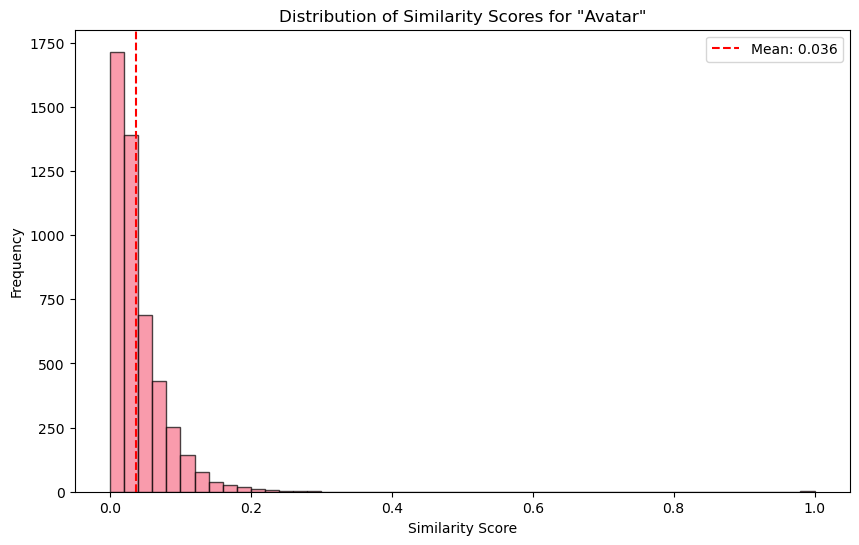

In [14]:
# Analyze similarities for Avatar
analyze_similarities('Avatar')

In [ ]:
# app.py
import streamlit as st
import pickle
import pandas as pd
import numpy as np
import plotly.express as px

# Page configuration
st.set_page_config(
    page_title="🎬 TMDB Movie Recommendation System",
    page_icon="🎬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Load model data
@st.cache_resource
def load_data():
    try:
        movie_list = pickle.load(open("movie_list.pkl", "rb"))
        similarity = pickle.load(open("similarity.pkl", "rb"))
        return movie_list, similarity
    except FileNotFoundError:
        st.error("""
        🚨 **Model files not found!**

        Please make sure the following files exist in the app directory:
        - `movie_list.pkl`: Contains movie metadata
        - `similarity.pkl`: Contains cosine similarity matrix
        """)
        return None, None

# Custom CSS
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        color: #FF6B6B;
        text-align: center;
        margin-bottom: 2rem;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.1);
    }
    .movie-card {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 1.5rem;
        border-radius: 15px;
        margin: 1rem 0;
        color: white;
        box-shadow: 0 4px 15px rgba(0,0,0,0.1);
        transition: transform 0.3s ease;
    }
    .movie-card:hover {
        transform: translateY(-2px);
    }
    .metric-card {
        background: #f8f9fa;
        padding: 1.5rem;
        border-radius: 10px;
        text-align: center;
        box-shadow: 0 2px 10px rgba(0,0,0,0.05);
    }
    .recommendation-title {
        background: linear-gradient(90deg, #667eea, #764ba2);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        font-size: 1.5rem;
        font-weight: bold;
        margin: 1rem 0;
    }
    .stSelectbox > div > div > div {
        background-color: #f8f9fa;
    }
</style>
""", unsafe_allow_html=True)

# Recommendation logic
def recommend(movie_title, movie_list, similarity, n=10):
    if movie_title not in movie_list['title'].values:
        return "❌ Movie not found!"

    idx = movie_list[movie_list['title'] == movie_title].index[0]
    distances = similarity[idx]
    movie_scores = list(enumerate(distances))
    movie_scores = sorted(movie_scores, key=lambda x: x[1], reverse=True)[1:n+1]

    recommendations = []
    for i, score in movie_scores:
        recommendations.append({
            "title": movie_list.iloc[i]['title'],
            "movie_id": movie_list.iloc[i]['movie_id'],
            "similarity_score": score
        })
    return recommendations

# Display movie card
def display_movie_info(title, similarity_score=None, rank=None):
    card_html = f"""
    <div class="movie-card">
        <div style="display: flex; justify-content: space-between; align-items: center;">
            <h3 style="margin: 0; color: white;">
                {f"#{rank} " if rank else ""}{title}
            </h3>
            <div style="text-align: right;">
                {f'<span style="background: rgba(255,255,255,0.2); padding: 5px 10px; border-radius: 15px; font-size: 0.9rem;">Similarity: {similarity_score:.3f}</span>' if similarity_score else ''}
            </div>
        </div>
    </div>
    """
    st.markdown(card_html, unsafe_allow_html=True)

# Bar chart
def create_similarity_chart(recommendations):
    titles = [rec['title'][:20] + '...' if len(rec['title']) > 20 else rec['title'] 
              for rec in recommendations]
    scores = [rec['similarity_score'] for rec in recommendations]
    
    fig = px.bar(
        x=titles,
        y=scores,
        title="📊 Similarity Scores",
        labels={'x': 'Movies', 'y': 'Similarity Score'},
        color=scores,
        color_continuous_scale='viridis'
    )
    
    fig.update_layout(
        xaxis_tickangle=-45,
        height=400,
        showlegend=False,
        font=dict(size=12),
        title_font_size=16
    )
    
    return fig

# Download table
def create_recommendations_dataframe(recommendations):
    df = pd.DataFrame(recommendations)
    df['Rank'] = range(1, len(df) + 1)
    df = df[['Rank', 'title', 'similarity_score', 'movie_id']]
    df.columns = ['Rank', 'Movie Title', 'Similarity Score', 'Movie ID']
    return df

# Main app
def main():
    st.markdown('<h1 class="main-header">🎬 TMDB Movie Recommendation System</h1>', unsafe_allow_html=True)

    st.markdown("""
    <div style='text-align: center; margin-bottom: 2rem; color: #666;'>
        <p>Discover movies similar to your favorites using advanced content-based filtering</p>
    </div>
    """, unsafe_allow_html=True)

    movie_list, similarity = load_data()
    if movie_list is None:
        st.stop()

    movie_titles = movie_list['title'].tolist()

    # Sidebar UI
    with st.sidebar:
        st.header("🎯 Movie Recommender")

        search_term = st.text_input("🔍 Search for a movie:", placeholder="Type to search...")
        if search_term:
            filtered = [m for m in movie_titles if search_term.lower() in m.lower()]
            if not filtered:
                st.warning("No matches found.")
                filtered = movie_titles[:10]
        else:
            filtered = movie_titles

        selected_movie = st.selectbox("Choose a movie:", options=filtered)
        num_recommendations = st.slider("Number of recommendations:", 1, 20, 10)
        get_recs_button = st.button("🚀 Get Recommendations", type="primary")

        st.markdown("---")
        with st.expander("📊 Dataset Information"):
            st.write(f"**Total Movies:** {len(movie_list):,}")
            st.write(f"**Algorithm:** Content-based filtering")
            st.write("**Similarity:** Cosine similarity with TF-IDF")

    if selected_movie and get_recs_button:
        st.markdown("### 🎥 Selected Movie")
        display_movie_info(selected_movie)

        with st.spinner("🔄 Finding similar movies..."):
            results = recommend(selected_movie, movie_list, similarity, n=num_recommendations)

            if isinstance(results, str):
                st.error(results)
            elif results:
                st.markdown("### 🎯 Recommended Movies")
                for i, rec in enumerate(results, 1):
                    display_movie_info(rec['title'], rec['similarity_score'], rank=i)

                st.markdown("### 📈 Recommendation Analytics")
                col1, col2 = st.columns([2, 1])
                scores = [rec['similarity_score'] for rec in results]

                with col1:
                    fig = create_similarity_chart(results)
                    st.plotly_chart(fig, use_container_width=True)
                with col2:
                    st.metric("Avg Similarity", f"{np.mean(scores):.3f}")
                    st.metric("Max Similarity", f"{max(scores):.3f}")
                    st.metric("Min Similarity", f"{min(scores):.3f}")

                st.markdown("### 💾 Export Results")
                df = create_recommendations_dataframe(results)
                st.dataframe(df, use_container_width=True)
                csv = df.to_csv(index=False)
                st.download_button(
                    "📥 Download as CSV", 
                    data=csv, 
                    file_name=f"recommendations_{selected_movie.replace(' ', '_')}.csv",
                    mime="text/csv"
                )
            else:
                st.warning("⚠️ No recommendations found.")

    elif selected_movie:
        st.markdown("### 🎥 Selected Movie")
        display_movie_info(selected_movie)
        st.info("👆 Click 'Get Recommendations' to find similar movies!")

    else:
        st.markdown("### 🚀 Get Started")
        st.info("""
        1. **Search** for a movie in the sidebar
        2. **Select** your favorite
        3. **Adjust** how many recommendations you want
        4. **Click** 'Get Recommendations'
        """)

        st.markdown("### 🎬 Popular Movies")
        cols = st.columns(2)
        for i, movie in enumerate(movie_titles[:10]):
            with cols[i % 2]:
                if st.button(f"🎯 {movie}", key=f"sample_{i}"):
                    st.session_state['movie'] = movie
                    st.rerun()

    st.markdown("---")
    st.markdown("""
    <div style='text-align: center; color: #666; margin-top: 2rem;'>
        <p>🛠️ <strong>Built with:</strong> Streamlit • scikit-learn • NLTK • Plotly</p>
        <p>📊 <strong>Algorithm:</strong> TF-IDF + Cosine Similarity</p>
        <p>🎬 <strong>Dataset:</strong> TMDB 5000 Movies</p>
    </div>
    """, unsafe_allow_html=True)

if __name__ == "__main__":
    main()


Saving the model...
Model saved successfully!
Files created:
- movie_list.pkl: Contains movie data
- similarity.pkl: Contains similarity matrix


In [ ]:

# %%
# Let's create a more advanced recommendation function for our final model
def get_detailed_recommendations(movie_title, n_recommendations=5):
    """
    Get detailed movie recommendations with similarity scores and movie info
    """
    try:
        # Find the movie
        movie_matches = new_df[new_df['title'].str.contains(movie_title, case=False, na=False)]
        
        if movie_matches.empty:
            return f"No movies found matching '{movie_title}'"
        
        # Use exact match if available, otherwise use first match
        if movie_title in new_df['title'].values:
            movie_index = new_df[new_df['title'] == movie_title].index[0]
        else:
            movie_index = movie_matches.index[0]
            movie_title = movie_matches.iloc[0]['title']
        
        # Get similarities
        distances = similarity[movie_index]
        movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:n_recommendations+1]
        
        print(f"🎬 Top {n_recommendations} recommendations for '{movie_title}':")
        print("=" * 70)
        
        recommendations = []
        for i, (idx, score) in enumerate(movies_list, 1):
            movie_info = {
                'rank': i,
                'title': new_df.iloc[idx]['title'],
                'similarity_score': score,
                'movie_id': new_df.iloc[idx]['movie_id']
            }
            recommendations.append(movie_info)
            
            print(f"{i:2d}. {movie_info['title']}")
            print(f"    Similarity Score: {score:.4f}")
            print(f"    Movie ID: {movie_info['movie_id']}")
            print()
        
        return recommendations
        
    except Exception as e:
        return f"Error getting recommendations: {str(e)}"

# 


In [ ]:
# Test our enhanced recommendation function
detailed_recs = get_detailed_recommendations('Avatar', 8)

# 
# Let's also test with partial movie names
print("Testing with partial movie name:")
detailed_recs = get_detailed_recommendations('Iron', 5)

# 
# Final model statistics and summary
print("🎯 MOVIE RECOMMENDATION SYSTEM - FINAL SUMMARY")
print("=" * 60)
print(f"📊 Dataset Statistics:")
print(f"   - Total movies processed: {len(new_df):,}")
print(f"   - Feature vector dimensions: {vectors.shape[1]:,}")
print(f"   - Similarity matrix size: {similarity.shape[0]:,} x {similarity.shape[1]:,}")


🎬 Top 8 recommendations for 'Avatar':
 1. Aliens vs Predator: Requiem
    Similarity Score: 0.2868
    Movie ID: 440

 2. Aliens
    Similarity Score: 0.2690
    Movie ID: 679

 3. Falcon Rising
    Similarity Score: 0.2605
    Movie ID: 270938

 4. Independence Day
    Similarity Score: 0.2556
    Movie ID: 602

 5. Titan A.E.
    Similarity Score: 0.2504
    Movie ID: 7450

 6. Battle: Los Angeles
    Similarity Score: 0.2451
    Movie ID: 44943

 7. Predators
    Similarity Score: 0.2446
    Movie ID: 34851

 8. Small Soldiers
    Similarity Score: 0.2368
    Movie ID: 11551

Testing with partial movie name:
🎬 Top 5 recommendations for 'Iron Man 3':
 1. Iron Man
    Similarity Score: 0.4370
    Movie ID: 1726

 2. Iron Man 2
    Similarity Score: 0.4234
    Movie ID: 10138

 3. Avengers: Age of Ultron
    Similarity Score: 0.3548
    Movie ID: 99861

 4. Captain America: Civil War
    Similarity Score: 0.3411
    Movie ID: 271110

 5. X-Men
    Similarity Score: 0.3336
    Movie ID: